<div style="text-align: center;">
  <div style="display: inline-block; min-width: 60%; font-weight: bold; font-size: 24px; color: black; background-color: yellow; padding: 15px 20px; border: 2px solid black; border-radius: 8px;">
    GOT-OCR-2.0 for Documents Pages Parsing
  </div>
</div>


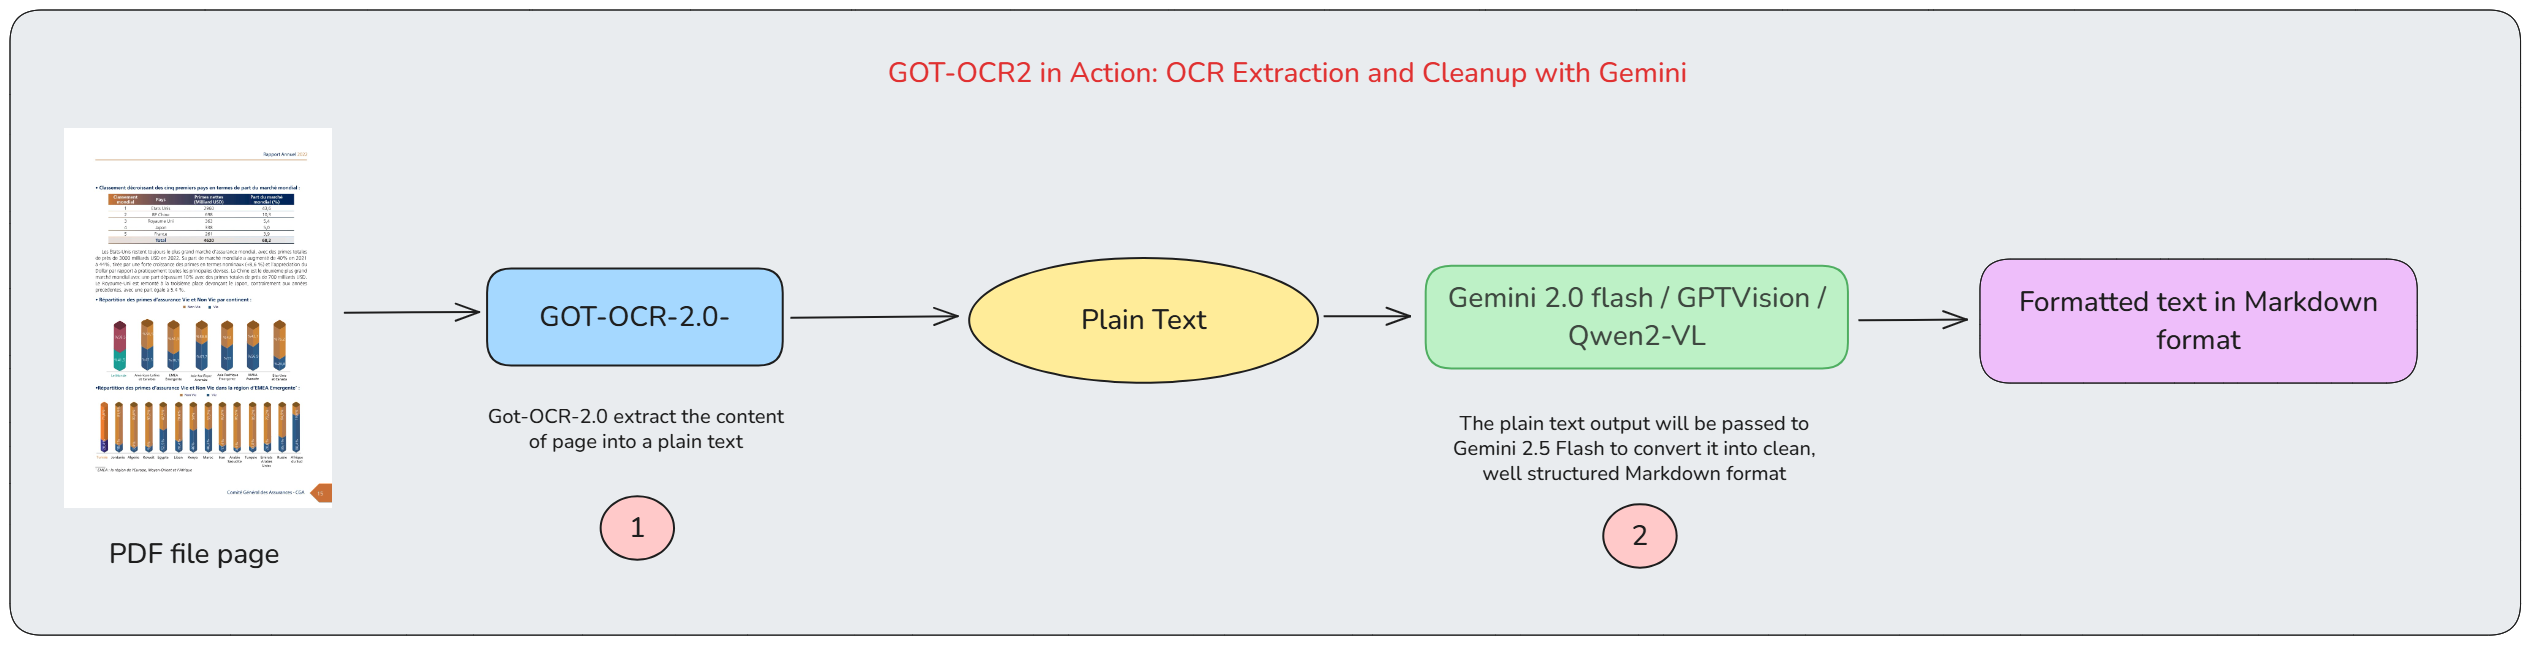

In this notebook, we evaluate **GOT-OCR2** for document page parsing to assess its OCR performance. While GOT-OCR2 supports **formatted text inference** (e.g., Markdown or LaTeX), we will use **plain text inference** instead, as it provides more accurate OCR results. Formatted text inference often struggles to capture all the content correctly, especially in complex layouts. To enhance the quality and presentation of the extracted text, we will use **Gemini 2.5 Flash** to correct and format the plain text output.

You can find the GOT-OCR2 model on Hugging Face here: [https://huggingface.co/stepfun-ai/GOT-OCR-2.0-hf](https://huggingface.co/stepfun-ai/GOT-OCR-2.0-hf)

# **1. Install Libraries**

In [1]:
%%capture
! pip install markdown2

# **2. Import Libraries**

In [20]:
import logging
import time
from pathlib import Path
import pandas as pd
from pdf2image import convert_from_path
import matplotlib.pyplot as plt
from PIL import Image
import os
import re

from IPython.display import display, HTML
import base64
import markdown
import markdown2

import io
from io import BytesIO, StringIO

import warnings
import sys
import contextlib

import torch
from transformers import AutoProcessor, AutoModelForImageTextToText
from google import genai
from google.genai import types

genai_api_key = "********************************"

# **3. Load GOT-OCR2_0 Model**

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

Using device: cuda


In [4]:
model = AutoModelForImageTextToText.from_pretrained("stepfun-ai/GOT-OCR-2.0-hf", device_map=device)
processor = AutoProcessor.from_pretrained("stepfun-ai/GOT-OCR-2.0-hf")

config.json:   0%|          | 0.00/608 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.


generation_config.json:   0%|          | 0.00/74.0 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/439 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/18.7M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/213 [00:00<?, ?B/s]

# **4. Inference**

In [5]:
def parse_doc_with_gotocr2_0(image_path):
    """
    Processes a document image using the GOT-OCR 2.0 model to extract and return the recognized text.

    Args:
        image_path (str): Path to the input image file.

    Returns:
        str: Extracted text from the document image.
    """
    inputs = processor(image_path, return_tensors="pt").to(device)
    
    generate_ids = model.generate(
        **inputs,
        do_sample=False,
        tokenizer=processor.tokenizer,
        stop_strings="<|im_end|>",
        max_new_tokens=4096,
    )
    
    res = processor.decode(generate_ids[0, inputs["input_ids"].shape[1]:], skip_special_tokens=True)
    return res

In [6]:
def correct_doc_content_with_gemini(txt_to_correct):
    """
    Uses the Gemini 2.5 Flash model to correct and format text into clean Markdown.

    Returns:
        str: Corrected and Markdown-formatted text.
    """
    client = genai.Client(api_key=genai_api_key)
    
    response = client.models.generate_content(
        model="gemini-2.5-flash",
        config=types.GenerateContentConfig(
            system_instruction="You are an expert in text processing; your task is to correct any spelling, grammar, \
            or formatting issues in the provided text and convert it into clean, well-structured Markdown format. \
            If the text includes tables, ensure they are properly formatted to display correctly in Markdown, \
            preserving the original meaning and improving overall clarity and presentation."),
        contents=txt_to_correct
    )
    
    return response.text

In [7]:
def display_text_with_pdf_or_image_plain(raw_text, file_path, pdf_page=0, max_width=800):
    warnings.filterwarnings('ignore', category=FutureWarning)
    warnings.filterwarnings('ignore', category=RuntimeWarning)
    
    # --- Image/PDF Display Part ---
    if file_path.lower().endswith(".pdf"):
        images = convert_from_path(file_path, first_page=pdf_page+1, last_page=pdf_page+1)
        img = images[0].convert("RGB")
    else:
        img = Image.open(file_path).convert("RGB")
    
    w_percent = max_width / float(img.width)
    new_height = int(float(img.height) * w_percent)
    img = img.resize((max_width, new_height), Image.LANCZOS)
    
    buffer = BytesIO()
    img.save(buffer, format="JPEG", quality=70)
    img_data = base64.b64encode(buffer.getvalue()).decode()
    html = f"""
    <div style="text-align: center;">
        <img src="data:image/jpeg;base64,{img_data}" style="width: 100%; border: 1px solid #ccc;" />
    </div>
    """
    display(HTML(html))

    # --- Markdown as plain text + tables as DataFrames ---
    html_tables = list(re.finditer(r'(<table[\s\S]*?</table>)', raw_text, re.IGNORECASE))
    last_end = 0
    for match in html_tables:
        text_before = raw_text[last_end:match.start()]
        if text_before.strip():
            print(text_before.strip())
            print('-' * 40)
        table_html = match.group(1)
        try:
            with warnings.catch_warnings():
                warnings.simplefilter("ignore", FutureWarning)
                warnings.simplefilter("ignore", RuntimeWarning)
                df_list = pd.read_html(StringIO(table_html))
                for df in df_list:
                    df = df.fillna("")
                    df.columns = df.iloc[0]
                    df = df[1:].reset_index(drop=True)
                    display(df)
        except Exception as e:
            print("Error parsing HTML table:", e)
        last_end = match.end()
    # Print any remaining text after the last table
    if last_end < len(raw_text):
        text_after = raw_text[last_end:].strip()
        if text_after:
            print(text_after)

## **Example n°1**


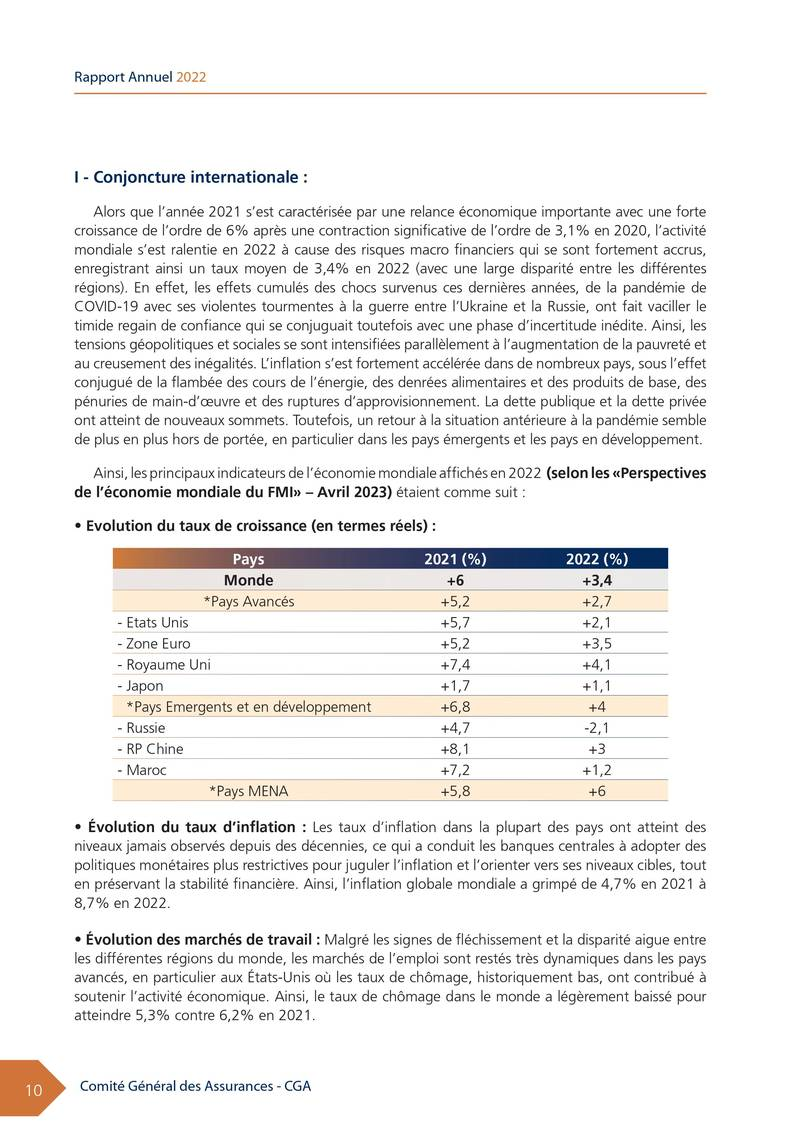

# Rapport Annuel 2022

## Comité Général des Assurances - CGA

---

### I - Conjoncture internationale

Alors que l’année 2021 s’est caractérisée par une relance économique importante avec une forte croissance de l’ordre de 6% après une contraction significative de l’ordre de 3,1% en 2020, l’activité mondiale s’est ralentie en 2022 à cause des risques macrofinanciers qui se sont fortement accrus, enregistrant ainsi un taux moyen de 3,4% en 2022 (avec une large disparité entre les différentes régions). En effet, les effets cumulés des chocs survenus ces dernières années, de la pandémie de COVID-19 avec ses violentes tourmentes à la guerre entre l’Ukraine et la Russie, ont fait vaciller le timide regain de confiance qui se conjuguait toutefois avec une phase d’incertitude inédite.

Ainsi, les tensions géopolitiques et sociales se sont intensifiées parallèlement à l’augmentation de la pauvreté et au creusement des inégalités. L’inflation s’est fortement accélérée dans de nombreux pays, so

In [8]:
text_to_corr = parse_doc_with_gotocr2_0("/kaggle/input/cga-images/RAP_CGA_FR_ANG_2022-images-10.jpg")
text_corr = correct_doc_content_with_gemini(text_to_corr)
display_text_with_pdf_or_image_plain(
    text_corr, 
    "/kaggle/input/cga-images/RAP_CGA_FR_ANG_2022-images-10.jpg"
)

## **Example n°2**


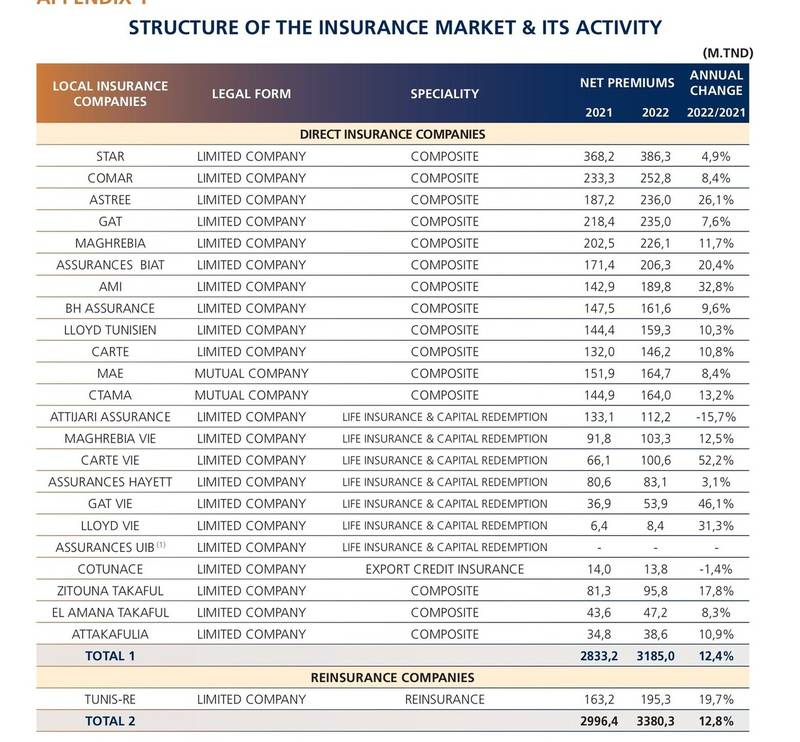

# Structure of the Insurance Market & Its Activity

*Amounts in Million Tunisian Dinars (M.TND)*

| Company                        | Legal Form      | Specialty                           | Net Premiums (M.TND) 2021 | Net Premiums (M.TND) 2022 | Annual Change (2022/2021) |
| :----------------------------- | :-------------- | :---------------------------------- | ------------------------: | ------------------------: | ------------------------: |
| **LOCAL INSURANCE COMPANIES**  |                 |                                     |                           |                           |                           |
| *Direct Insurance Companies*   |                 |                                     |                           |                           |                           |
| STAR                           | Limited Company | Composite                           | 368.2                     | 386.3                     | 4.9%                      |
| COMAR                    

In [9]:
text_to_corr = parse_doc_with_gotocr2_0("/kaggle/input/cga-images/RAP_CGA_FR_ANG_2022-images-79 (1) (1).jpg")
text_corr = correct_doc_content_with_gemini(text_to_corr)
display_text_with_pdf_or_image_plain(
    text_corr, 
    "/kaggle/input/cga-images/RAP_CGA_FR_ANG_2022-images-79 (1) (1).jpg"
)

## **Example n°3**


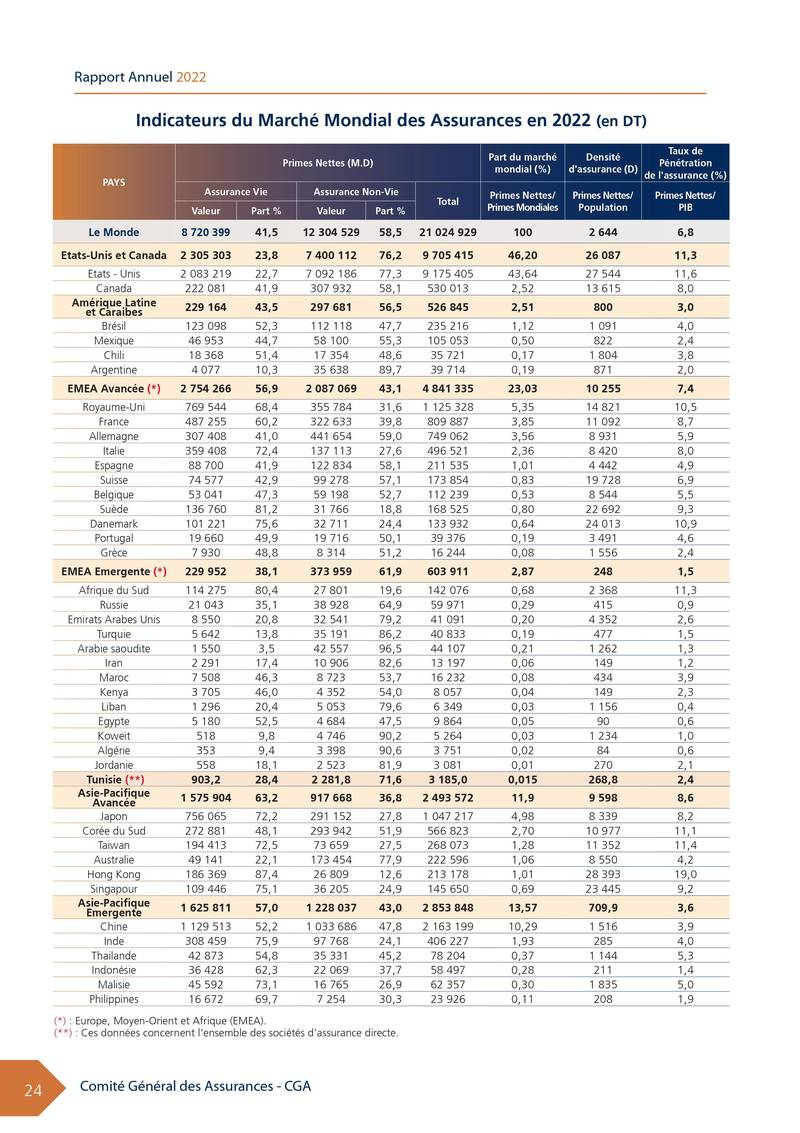

## Rapport Annuel 2022

### Comité Général des Assurances (CGA)

#### Indicateurs du Marché Mondial des Assurances en 2022 (en DT)

| Pays | Primes Nettes (MDT) | Pénétration de l'assurance (%) | Piruses Nettes/Pilques |
| :--- | :------------------ | :----------------------------- | :--------------------- |
|      |                     |                                |                        |
|      |                     |                                |                        |
|      |                     |                                |                        |

**Note:** The column header "Piruses Nettes/Pilques" was repeated multiple times in the original source, possibly due to an OCR or formatting error. It has been included only once for clarity. No data was provided under any of the columns. The specific meaning of "Piruses Nettes/Pilques" is unclear and likely represents a transcription error.


In [10]:
text_to_corr = parse_doc_with_gotocr2_0("/kaggle/input/different-tables-images-testing/other_table.jpg")
text_corr = correct_doc_content_with_gemini(text_to_corr)
display_text_with_pdf_or_image_plain(
    text_corr, 
    "/kaggle/input/different-tables-images-testing/other_table.jpg"
)

## **Example n°4**


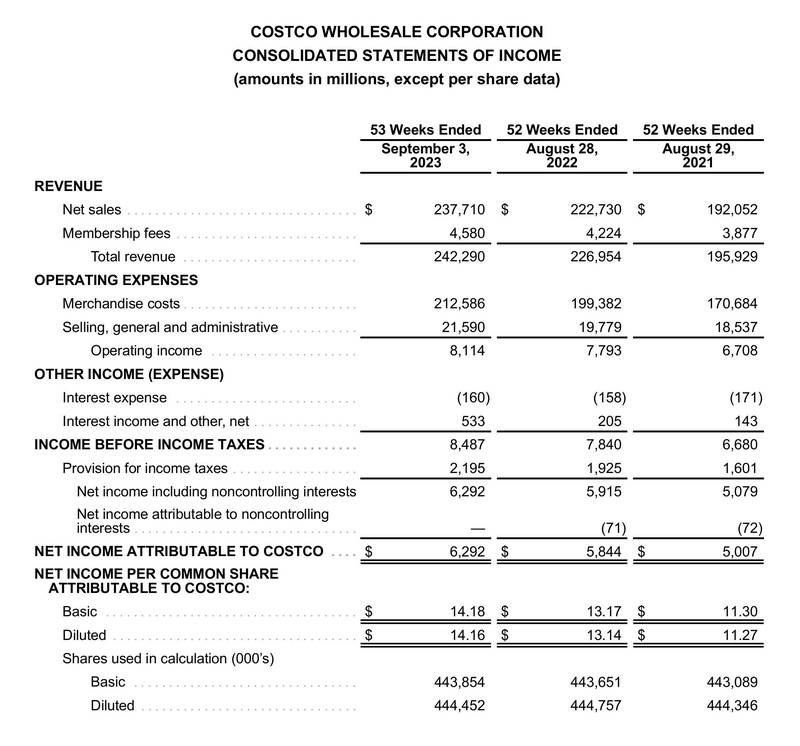

**COSTCO WHOLESALE CORPORATION**

**CONSOLIDATED STATEMENTS OF INCOME**
(amounts in millions, except per share data)


In [11]:
text_to_corr = parse_doc_with_gotocr2_0("/kaggle/input/different-tables-images-testing/table_2.jpg")
text_corr = correct_doc_content_with_gemini(text_to_corr)
display_text_with_pdf_or_image_plain(
    text_corr, 
    "/kaggle/input/different-tables-images-testing/table_2.jpg"
)

## **Example n°5**


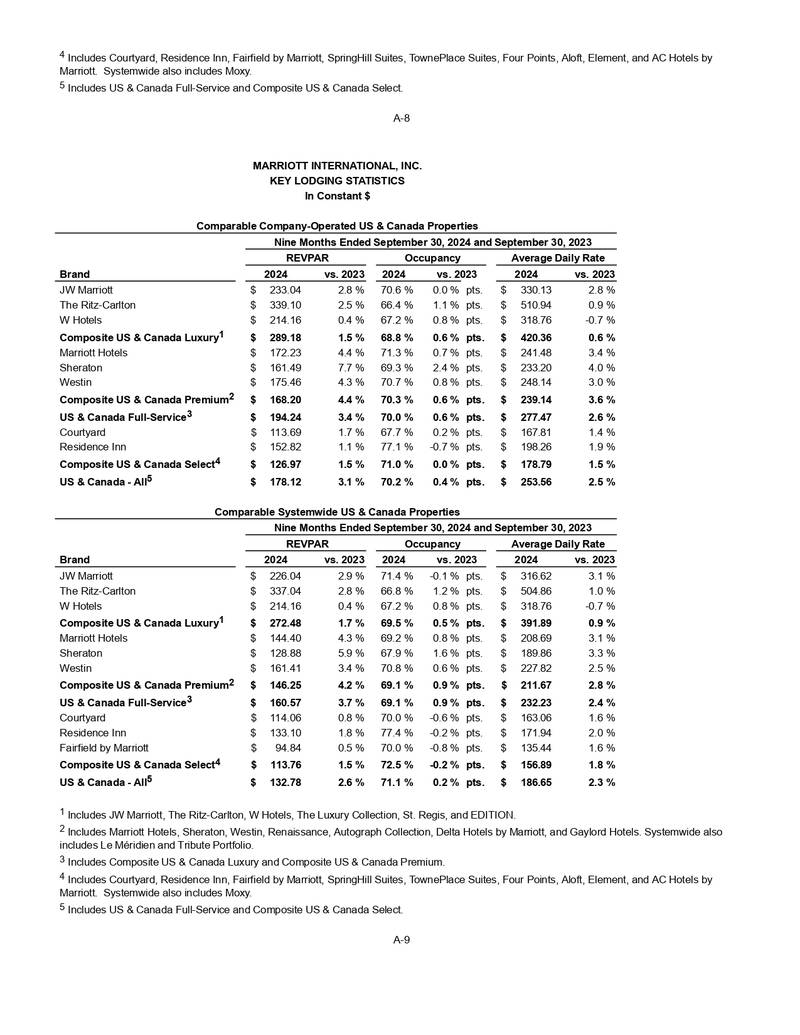

Here's the corrected and well-structured Markdown version of your text:

***

Page A-8

**MARRIOTT INTERNATIONAL, INC.**
**KEY LODGING STATISTICS**
In Constant $

**Notes for Tables on Pages A-8 and A-9:**

*   **Note 1:** Includes JW Marriott, The Ritz-Carlton, W Hotels, The Luxury Collection, St. Regis, and EDITION.
*   **Note 2:** Includes Marriott Hotels, Sheraton, Westin, Renaissance, Autograph Collection, Delta Hotels by Marriott, and Gaylord Hotels. Systemwide also includes Le Méridien and Tribute Portfolio.
*   **Note 3:** Includes Composite US & Canada Luxury and Composite US & Canada Premium.
*   **Note 4:** Includes Courtyard, Residence Inn, Fairfield by Marriott, Springhill Suites, TownePlace Suites, Four Points, Aloft, Element, and AC Hotels by Marriott. Systemwide also includes Moxy.
*   **Note 5:** Includes US & Canada Full-Service and Composite US & Canada Select.

---

### Comparable Company Operated US & Canada Properties
Nine Months Ended September 30, 2024 and Septe

In [12]:
text_to_corr = parse_doc_with_gotocr2_0("/kaggle/input/pdf-files-pages/Marriott International Reports Third Quarter 2024 Results_page-0011.jpg")
text_corr = correct_doc_content_with_gemini(text_to_corr)
display_text_with_pdf_or_image_plain(
    text_corr, 
    "/kaggle/input/pdf-files-pages/Marriott International Reports Third Quarter 2024 Results_page-0011.jpg"
)

## **Example n°6**


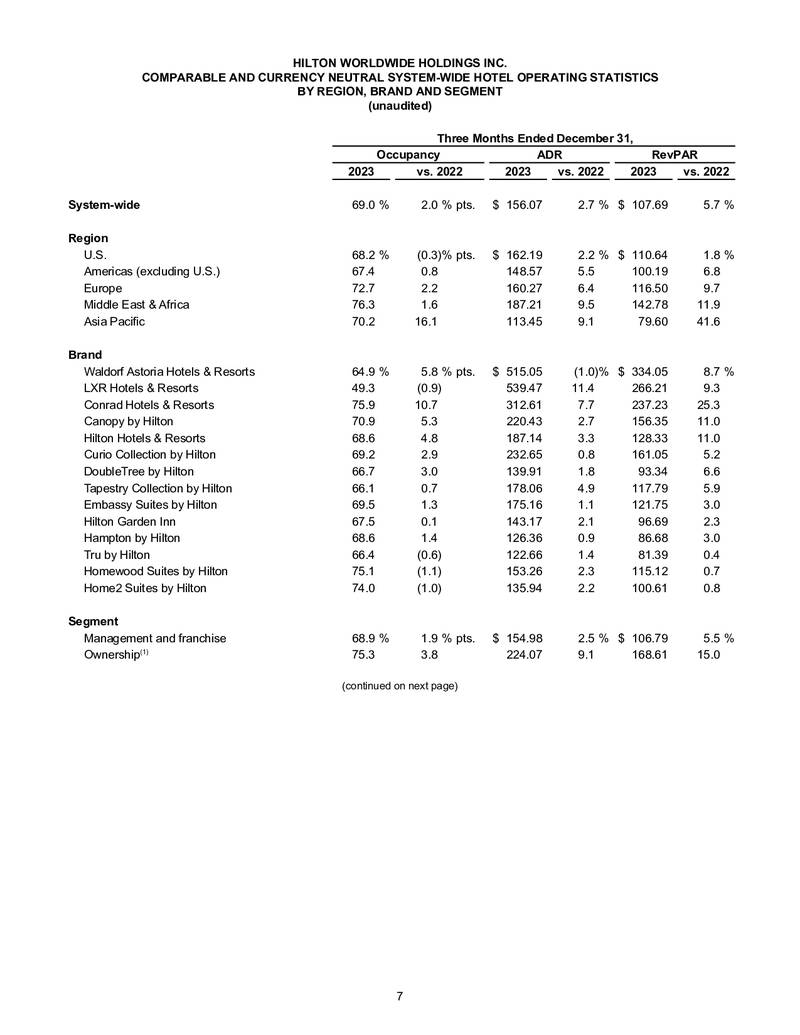

# HILTON WORLDWIDE HOLDINGS INC.

## COMPARABLE AND CURRENCY NEUTRAL SYSTEM-WIDE HOTEL OPERATING STATISTICS BY REGION, BRAND AND SEGMENT

(Unaudited)

**Three Months Ended December 31, 2023**

| Category                       | 2023 Occupancy (%) | vs. 2022 (pts.) |
| :----------------------------- | :----------------: | :-------------: |
| **System-wide**                |       69.0         |       2.0       |
| **Region**                     |                    |                 |
| U.S.                           |       68.2         |                 |
| Americas (excluding U.S.)      |       67.4         |                 |
| Europe                         |       67.2         |                 |
| Middle East & Africa           |       72.7         |                 |
| Asia Pacific                   |       76.3         |                 |
| **Brand**                      |                    |                 |
| LXR Hotels & Resorts           |       64.9         |            

In [13]:
text_to_corr = parse_doc_with_gotocr2_0("/kaggle/input/pdf-files-pages/q4-2023-earnings-release_page-0007.jpg")
text_corr = correct_doc_content_with_gemini(text_to_corr)
display_text_with_pdf_or_image_plain(
    text_corr, 
    "/kaggle/input/pdf-files-pages/q4-2023-earnings-release_page-0007.jpg"
)

## **Example n°7**


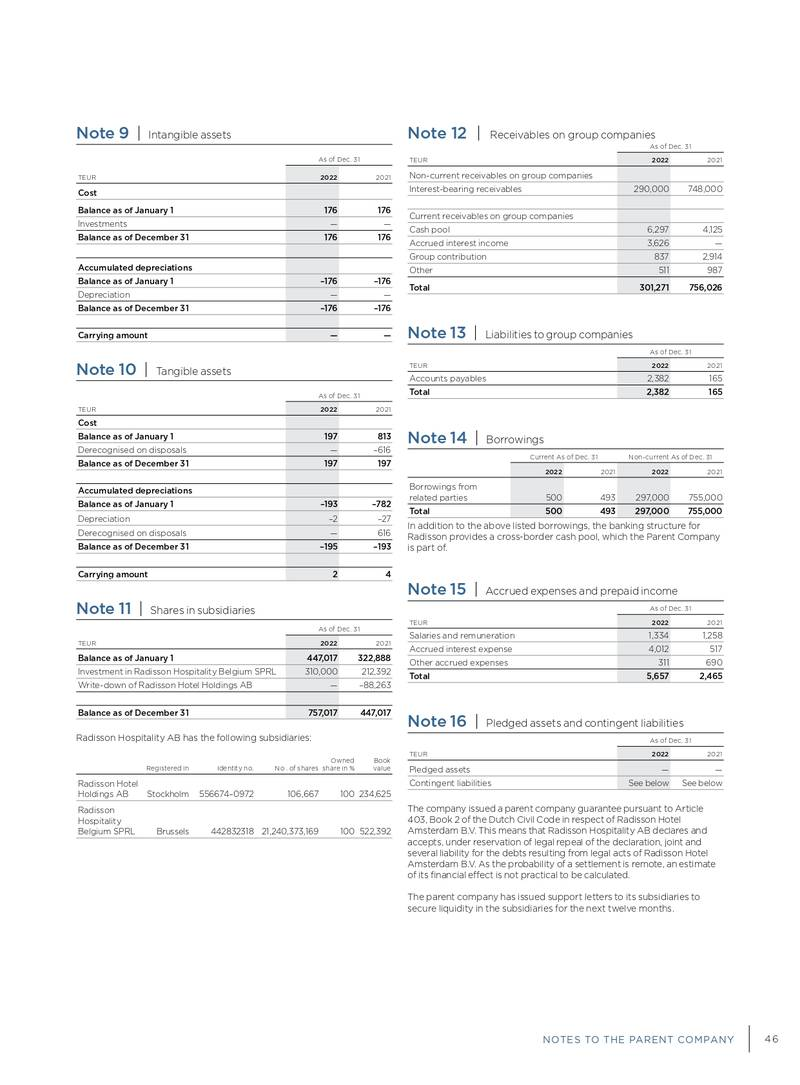

Here is the corrected and well-structured Markdown version of the provided text:

---

## Note 9 | Intangible Assets

As of Dec. 31 (TEUR)

| Description                  | 2022 | 2021 |
| :--------------------------- | ---: | ---: |
| **Cost**                     |      |      |
| Balance as of January 1      |  176 |  176 |
| Investments                  |    - |    - |
| Balance as of December 31    |  176 |  176 |
| **Accumulated Depreciation** |      |      |
| Balance as of January 1      | -176 | -176 |
| Depreciation                 |    - |    - |
| Balance as of December 31    | -176 | -176 |
| **Carrying amount**          |    - |    - |

---

## Note 10 | Tangible Assets

As of Dec. 31 (TEUR)

| Description                  | 2022 | 2021 |
| :--------------------------- | ---: | ---: |
| **Cost**                     |      |      |
| Balance as of January 1      |  197 |  813 |
| Depreciation on disposals    |    - | -616 |
| Balance as of December 31    |  197 |  197 |
| *

In [18]:
text_to_corr = parse_doc_with_gotocr2_0("/kaggle/input/pdf-files-pages/RHG_annual_report_2022_page-0047.jpg")
text_corr = correct_doc_content_with_gemini(text_to_corr)
display_text_with_pdf_or_image_plain(
    text_corr, 
    "/kaggle/input/pdf-files-pages/RHG_annual_report_2022_page-0047.jpg"
)

## **Example n°8**


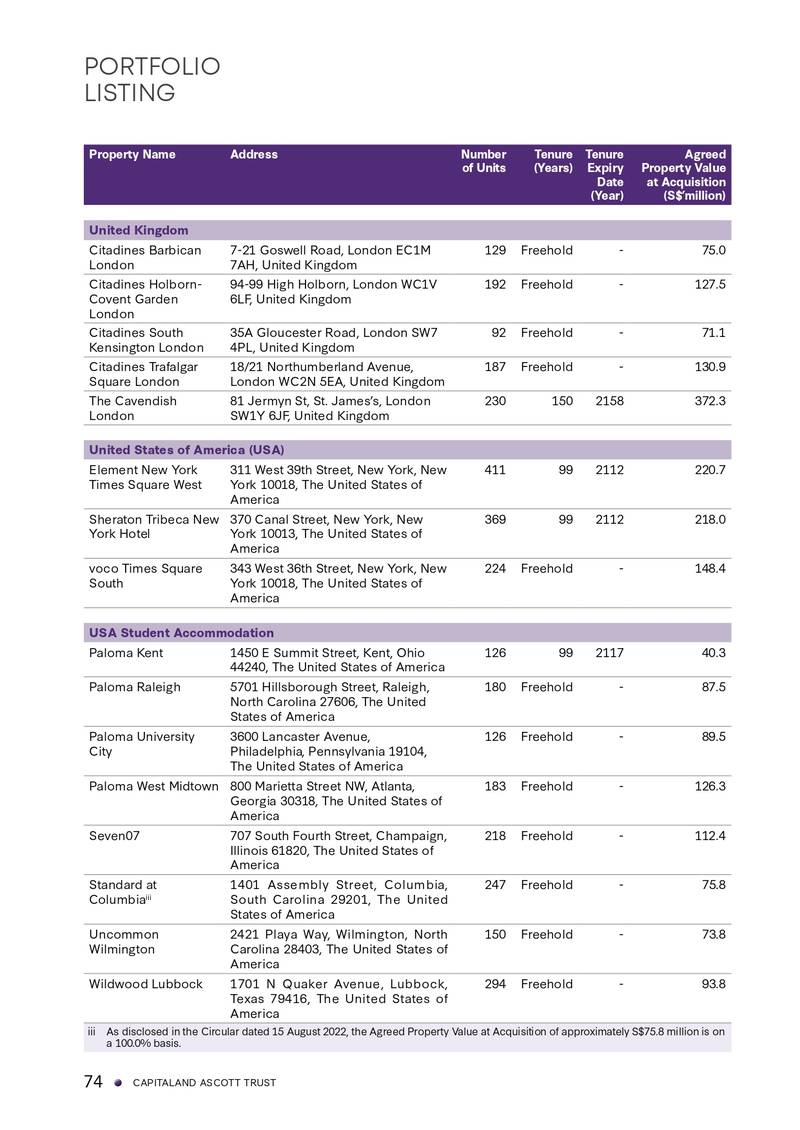

# CAPITALAND ASCOTT TRUST Portfolio Listing

This section details the portfolio of properties owned by CapitaLand Ascott Trust, including their key attributes such as number of units, tenure, and agreed property value at acquisition.

| Property Name                                        | Number of Units | Tenure (Years) | Tenure Expiry Date (Year) | Agreed Property Value at Acquisition (S$ million) |
| :--------------------------------------------------- | :-------------- | :------------- | :------------------------ | :------------------------------------------------ |
| **United Kingdom**                                   |                 |                |                           |                                                   |
| Citadines Barbican London<br/>7-21 Goswell Road, London EC1M 7AH, United Kingdom | 129             | Freehold       | -                         | 75.0                                              |
| Citadines Holborn-Covent Garden London<br/>94-9

In [19]:
text_to_corr = parse_doc_with_gotocr2_0("/kaggle/input/pdf-files-pages/CLAS-FY2023-AR_page-0076.jpg")
text_corr = correct_doc_content_with_gemini(text_to_corr)
display_text_with_pdf_or_image_plain(
    text_corr, 
    "/kaggle/input/pdf-files-pages/CLAS-FY2023-AR_page-0076.jpg"
)

# **5. Conclusion**

<div style="background-color:#ffcccc; color:#000000; padding:15px; border-radius:8px;">
  While GOT-OCR2 showed promising capabilities, it struggled to extract text accurately in several sections of the documents. These OCR limitations directly impacted the final output quality. It's important to note that the issues observed in the structured Markdown output were primarily due to incomplete or incorrect OCR results from GOT-OCR2, not Gemini 2.5 Flash.
</div>
